In [1]:
from utils.binaries import *
from utils.plotting import *

from scipy.optimize import curve_fit
from scipy.special import expit
from scipy.integrate import quad
from scipy.stats import landau


13:43:37 (  +21.3s) [INFO   ] -- import logging


13:43:37 (  +118ms) [INFO   ] -- import numpy as np
13:43:37 (    +5ms) [INFO   ] -- import uncertainties
13:43:37 (    +5ms) [INFO   ] -- import uncertainties
13:43:38 (  +260ms) [INFO   ] -- import pandas as pd
13:43:38 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
13:43:38 (    +1ms) [INFO   ] -- import binaries.tools as tools
13:43:38 (  +306ms) [INFO   ] -- import matplotlib.pyplot as plt
13:43:38 (  +504ms) [INFO   ] -- import seaborn as so
13:43:38 (    +2ms) [INFO   ] -- set MONI_PATH = PosixPath('/home/filip/Data/monit_and_sd')
13:43:38 (    +1ms) [INFO   ] -- set HIST_PATH = PosixPath('/home/filip/Data/monit_and_sd')
13:43:38 (    +1ms) [INFO   ] -- set PLOT_PATH = PosixPath('/home/filip/Data/plots')
13:43:38 (    +0ms) [INFO   ] -- set DATA_PATH = PosixPath('/home/filip/Data')
13:43:38 (    +1ms) [INFO   ] -- set SCAN_PATH = PosixPath('/home/filip/Public/xy-calibration')
13:43:38 (    +1ms) [INFO   ] -- set OFLN_PATH = PosixPath('/home/filip/Public/offl

Text(0.5, 0, '$I^\\mathrm{SSD}_\\mathrm{histo}$')

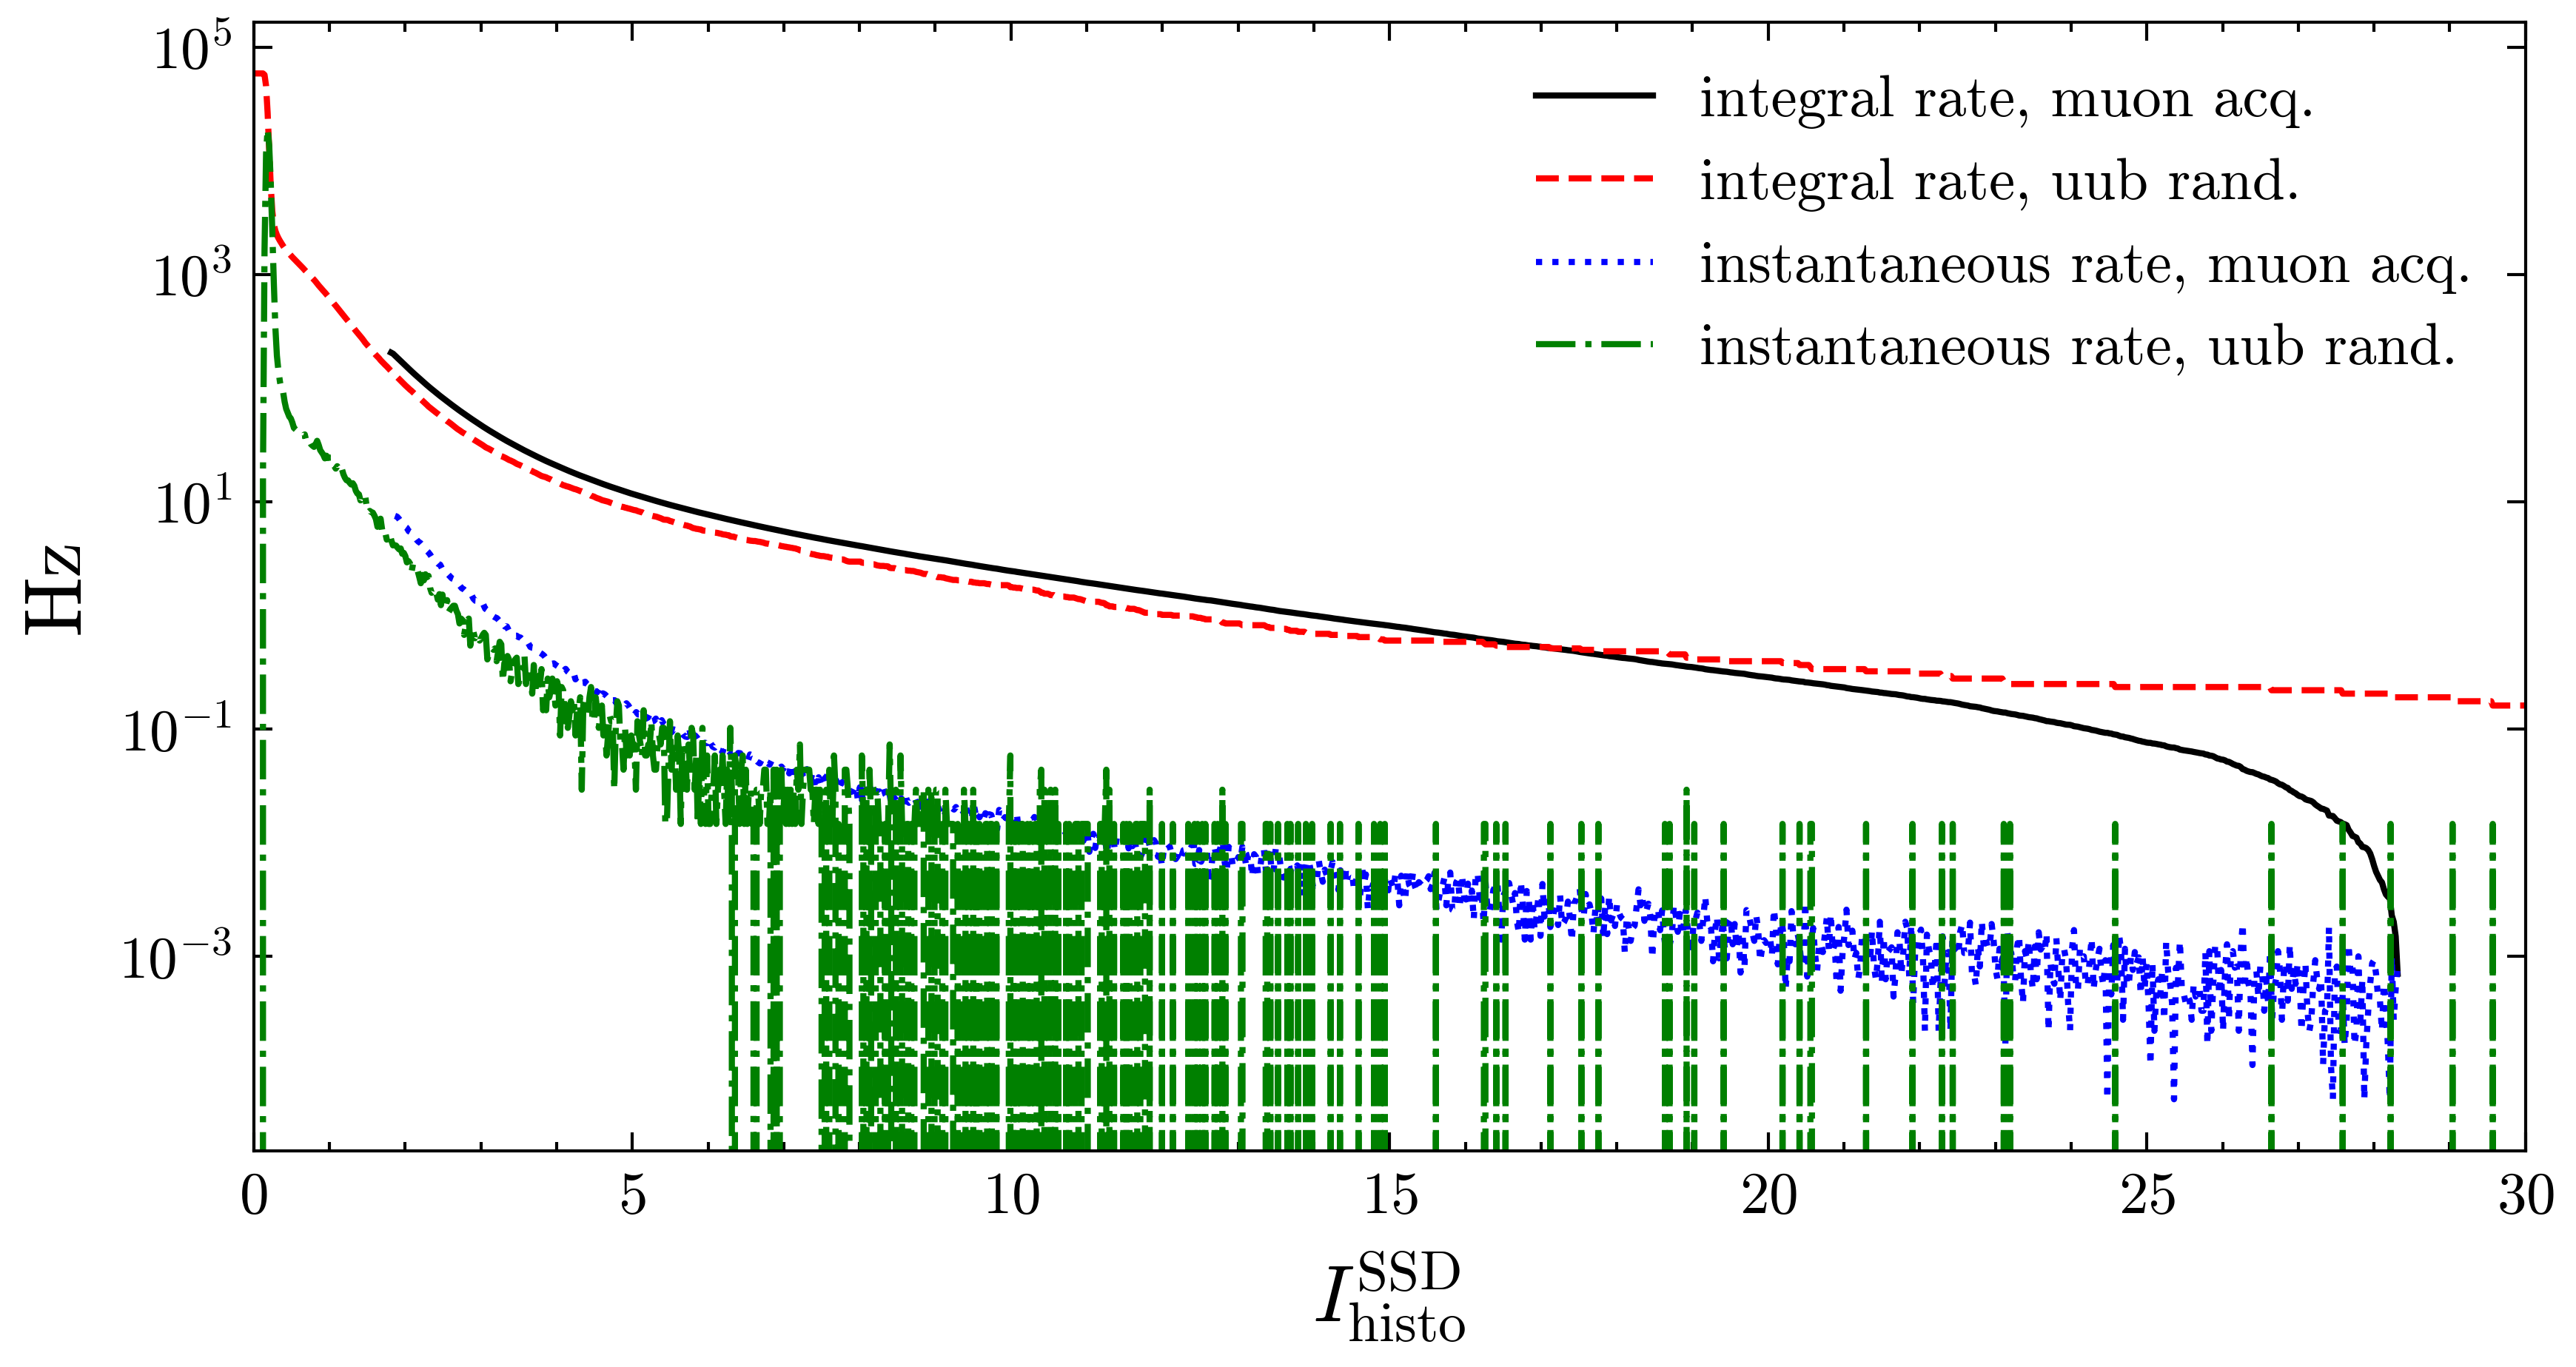

In [2]:
x, y = np.loadtxt('mean_rates_t3_mip.txt', unpack=True)
obj = tools.pickle_load('pulse_height_distribution.pkl')[0]
x_rand, y_rand = obj[:, 0], np.cumsum(obj[:, 1][::-1])[::-1]
inst_y_rand = -np.diff(y_rand[1:])

inst_y = -np.diff(y[1:])

def llandau(x, norm, loc, scale, suppression, cutoff):
    return norm * landau(loc, scale).pdf(x) * (1 - expit((x-cutoff)*suppression))

popt, pcov = curve_fit(llandau, x[2:], inst_y,
                       bounds=([0, 0, 0, 0, 0],[np.inf, np.inf, np.inf, np.inf, np.inf]),
                       p0=[31.88461781, 1.71248985, 0.34490904, 0., 0],
                       sigma=np.sqrt(inst_y/60))

plt.plot(x, y, label='integral rate, muon acq.')
plt.plot(x_rand, y_rand, label='integral rate, uub rand.', marker='none')
plt.plot(x[2:], inst_y, label='instantaneous rate, muon acq.', marker='none')
plt.plot(x_rand[2:], inst_y_rand, label='instantaneous rate, uub rand.', marker='none')
# plt.plot(x[2:], llandau(x[2:], *popt), label='instantaneous fit', marker='none')
# plt.plot(x[2:], int_fit(x[2:]), label='fit integral', marker='none')

plt.legend()
plt.xlim(0, 30)
plt.ylabel("Hz")
plt.yscale('log')
plt.xlabel("$I^\mathrm{SSD}_\mathrm{histo}$")

In [5]:
# from data

t_cal = 10
t_70 = 50 / 48.94       # real world values
adjust = 0.2 / 48.94    # maybe this has an influence?
mip, rate = np.loadtxt('mean_rates_t3_mip.txt', unpack=True)
i_ssd, inst_rate = mip[2:], -np.diff(rate[1:])

n_repeat = 15

while t_cal <= 60 or n_repeat:


    # create events
    peaks = np.array([])
    for x, y in zip(i_ssd, inst_rate):
        peaks = np.append(peaks, [x] * np.random.poisson(y * t_cal))
    
    # calculate trigger rate
    n_above = sum(peaks >= t_70)
    trigger_rate = n_above / t_cal
    sigma = np.sqrt(trigger_rate)
    delta = trigger_rate - 70

    match delta:
        case _ if np.abs(delta) < sigma:
            adjust -= 0.01 / 48.94
            t_cal += 5
        
        case _ if np.abs(delta) < 5:
            adjust = 0.1 / 48.94

        case _ if np.abs(delta) < 20:
            pass
        
        case _:
            adjust = 1.0 / 48.94
            t_cal = 10

    t_cal = min([61, np.max([10, t_cal])])
    adjust = min([1. / 48.94, np.max([0.01 / 48.94, t_cal])])

    if delta > 0: t_70 += adjust
    else:         t_70 -= adjust

    if t_cal >= 60: 
        n_repeat -= 1
        
        print(f"after {t_cal = } s, rate was {trigger_rate:.2f} Hz and threshold will be {t_70:.2f} (= {t_70/2.64-1:.2f})")

after t_cal = np.int64(60) s, rate was 69.44 Hz and threshold will be 2.64 (= -0.00)
after t_cal = 61 s, rate was 70.97 Hz and threshold will be 2.66 (= 0.01)
after t_cal = 61 s, rate was 67.90 Hz and threshold will be 2.64 (= -0.00)
after t_cal = 61 s, rate was 71.05 Hz and threshold will be 2.66 (= 0.01)
after t_cal = 61 s, rate was 69.16 Hz and threshold will be 2.64 (= -0.00)
after t_cal = 61 s, rate was 69.41 Hz and threshold will be 2.62 (= -0.01)
after t_cal = 61 s, rate was 72.43 Hz and threshold will be 2.64 (= -0.00)
after t_cal = 61 s, rate was 72.57 Hz and threshold will be 2.66 (= 0.01)
after t_cal = 61 s, rate was 67.03 Hz and threshold will be 2.64 (= -0.00)
after t_cal = 61 s, rate was 72.18 Hz and threshold will be 2.66 (= 0.01)
after t_cal = 61 s, rate was 69.21 Hz and threshold will be 2.64 (= -0.00)
after t_cal = 61 s, rate was 72.15 Hz and threshold will be 2.66 (= 0.01)
after t_cal = 61 s, rate was 68.16 Hz and threshold will be 2.64 (= -0.00)
after t_cal = 61 s, 

In [4]:
# from randoms

t_cal = 10
t_70 = 50 / 48.94       # real world values
adjust = 0.2 / 48.94    # maybe this has an influence?
i_ssd, inst_rate = x_rand[72:], inst_y_rand[70:]
n_repeat = 15

while t_cal <= 60 or n_repeat:


    # create events
    peaks = np.array([])
    for x, y in zip(i_ssd, inst_rate):
        peaks = np.append(peaks, [x] * np.random.poisson(y * t_cal))
    
    # calculate trigger rate
    n_above = sum(peaks >= t_70)
    trigger_rate = n_above / t_cal
    sigma = np.sqrt(trigger_rate)
    delta = trigger_rate - 70

    match delta:
        case _ if np.abs(delta) < sigma:
            adjust -= 0.01 / 48.94
            t_cal += 5
        
        case _ if np.abs(delta) < 5:
            adjust = 0.1 / 48.94

        case _ if np.abs(delta) < 20:
            pass
        
        case _:
            adjust = 1.0 / 48.94
            t_cal = 10

    t_cal = min([61, np.max([10, t_cal])])
    adjust = min([1. / 48.94, np.max([0.01 / 48.94, t_cal])])

    if delta > 0: t_70 += adjust
    else:         t_70 -= adjust

    if t_cal >= 60: 
        n_repeat -= 1
        
        print(f"after {t_cal = } s, rate was {trigger_rate:.2f} Hz and threshold will be {t_70:.2f} (= {(t_70 - 2.64)/t_70:.2f})")

after t_cal = np.int64(60) s, rate was 70.42 Hz and threshold will be 2.35 (= -0.12)
after t_cal = 61 s, rate was 67.37 Hz and threshold will be 2.33 (= -0.13)
after t_cal = 61 s, rate was 68.84 Hz and threshold will be 2.31 (= -0.14)
after t_cal = 61 s, rate was 71.98 Hz and threshold will be 2.33 (= -0.13)
after t_cal = 61 s, rate was 69.41 Hz and threshold will be 2.31 (= -0.14)
after t_cal = 61 s, rate was 70.75 Hz and threshold will be 2.33 (= -0.13)
after t_cal = 61 s, rate was 67.46 Hz and threshold will be 2.31 (= -0.14)
after t_cal = 61 s, rate was 69.82 Hz and threshold will be 2.29 (= -0.15)
after t_cal = 61 s, rate was 72.07 Hz and threshold will be 2.31 (= -0.14)
after t_cal = 61 s, rate was 71.15 Hz and threshold will be 2.33 (= -0.13)
after t_cal = 61 s, rate was 69.36 Hz and threshold will be 2.31 (= -0.14)
after t_cal = 61 s, rate was 71.03 Hz and threshold will be 2.33 (= -0.13)
after t_cal = 61 s, rate was 70.90 Hz and threshold will be 2.35 (= -0.12)
after t_cal = 6

In [ ]:
# from fit

t_cal = 10
t_70 = 50 / 48.94       # real world values
adjust = 0.2 / 48.94    # maybe this has an influence?
mip, rate = np.loadtxt('mean_rates_t3_mip.txt', unpack=True)
i_ssd, inst_rate = mip[2:], -np.diff(rate[1:])

n_repeat = 5

popt_wo_supression = [6.23582273e+00, 2.03615735e+00, 2.71378320e-01, 0.00000000e-01, 0.00000000e-01]
popt_w_suppression = [1.87140748e+01, 1.90879654e+00, 3.13438255e-01, 1.17255626e-01, 4.87078402e-15]

f_with = lambda x: llandau(x, *popt_w_suppression)
f_without = lambda x: llandau(x, *popt_wo_supression)

while t_cal <= 60 or n_repeat:
    
    # calculate trigger rate
    integral_rate_above, _ = quad(f_without, t_70, np.inf)
    n_above = np.random.poisson(integral_rate_above * t_cal)
    trigger_rate = n_above / t_cal
    sigma = np.sqrt(trigger_rate)
    delta = trigger_rate - 70

    match delta:
        case _ if np.abs(delta) < sigma:
            adjust -= 0.01 / 48.94
            t_cal += 5
        
        case _ if np.abs(delta) < 5:
            adjust = 0.1 / 48.94

        case _ if np.abs(delta) < 20:
            pass
        
        case _:
            adjust = 1.0 / 48.94
            t_cal = 10

    t_cal = min([61, np.max([10, t_cal])])
    adjust = min([1. / 48.94, np.max([0.01 / 48.94, t_cal])])

    if delta > 0: t_70 += adjust
    else:         t_70 -= adjust

    if t_cal >= 60: 
        n_repeat -= 1
        
    print(f"after {t_cal = } s, rate was {trigger_rate:.2f} Hz and threshold will be {t_70:.2f} (= {t_70/2.64-1:.2f})")